In [1]:
#Installing the necessary libraries
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://bitbucket.org/habedi/datasets/raw/b6769c4664e7ff68b001e2f43bc517888cbe3642/spark/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!rm -rf spark-3.0.2-bin-hadoop2.7.tgz*
!pip -q install findspark pyspark graphframes

In [2]:
#Initializing the environment
import os
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"

In [3]:
from graphframes import *
from pyspark import *

In [4]:
!pip install pyspark

In [5]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import Imputer

session=SparkSession.builder.appName("machinelearninginspark").master("local").getOrCreate()
ecomm_churn_data=session.read.csv("e-commerce_churn.csv", header=True, inferSchema=True)

# SQL

In [6]:
# Register DataFrame as a temporary SQL table
ecomm_churn_data.createOrReplaceTempView("ecommerce_table")

# Write and execute Spark SQL query
query = """
    SELECT State, COUNT(*) as CustomerCount
    FROM ecommerce_table
    WHERE (TotalPurchase >= 700 AND (Age>20 OR Age<30)) AND Churn = 0
    GROUP BY State
    ORDER BY State
"""
result = session.sql(query)

# Show the results
result.show()

+----------+-------------+
|     State|CustomerCount|
+----------+-------------+
|California|            6|
|   Florida|           54|
|  New York|           21|
|     Texas|           53|
+----------+-------------+



The information from this study tells us about younger customers, aged between 20 and 30, who not only buy a lot but also stay loyal to the online shopping platform. By looking at where these customers live by states, the business can figure out which areas have more of these active and loyal customers. This helps the business focus its advertising and make decisions that match what these younger customers like in different parts of the country.

Talking about younger customers is important because they are really good with online shopping—they use digital tools easily. Getting younger customers involved early on can be a long-lasting relationship. If these customers keep buying a lot and stay loyal, they can bring in steady money for a long time.

Younger people often lead trends and influence others. Understanding what they like can affect a lot of other people. Younger customers are also good at trying out new things, like new technology or different kinds of products. This is helpful for businesses that want to bring in new ideas or change things up.

Younger customers are also more likely to stick with a brand they like. If they have a good experience and like the brand, they'll probably keep buying from it as they get older.

In simple terms, the study not only helps the business keep and attract valuable customers in certain areas but also takes advantage of the benefits of working with younger customers who are good with technology, influence others, try new things, and can stay loyal for a long time. It's all about building strong relationships and staying popular in the world of online shopping.

In [7]:
query2 = """
SELECT Brand, Gender, COUNT(*) as CustomerCount
FROM ecommerce_table
WHERE Churn = 1
GROUP BY Brand, Gender
ORDER BY Brand, Gender
"""
result2 = session.sql(query2)

# Show the results
result2.show()

+-------+------+-------------+
|  Brand|Gender|CustomerCount|
+-------+------+-------------+
| Adidas|Female|           41|
| Adidas|  Male|           17|
|  Apple|Female|           13|
|  Apple|  Male|           43|
|   Nike|Female|           11|
|   Nike|  Male|           36|
|Samsung|Female|           41|
|Samsung|  Male|           16|
+-------+------+-------------+




By grouping churned customers based on both 'Brand' and 'Gender,' the e-commerce platform gains insights into specific segments more prone to churn. Identifying higher churn rates within certain brand or gender groups highlights potential challenges in retaining customers in these segments. This analysis unveils patterns related to product preferences and marketing effectiveness, guiding adjustments in product positioning and messaging to enhance customer appeal. Efficient resource allocation becomes possible by understanding where the majority of churn occurs, allowing the business to focus marketing budgets and adjust inventory and promotions based on the preferences of identified brand and gender groups. In essence, this SQL query supports strategic decision-making by illuminating the interplay between brand, gender, and customer churn, facilitating the formulation of targeted strategies for sustained business growth.

# Feature Engineering of Numerical Values

In [8]:
print("Number of observations:",ecomm_churn_data.count())
print("Information of columns:\n",ecomm_churn_data.columns)
print("Description of columns:\n",ecomm_churn_data.describe().show())
print("First few records:\n", ecomm_churn_data.show(3))

Number of observations: 620
Information of columns:
 ['CustomerId', 'Name', 'Age', 'Gender', 'State', 'Brand', 'TotalPurchase', 'Churn']
+-------+------------------+----------------+------------------+------+----------+-------+-----------------+-------------------+
|summary|        CustomerId|            Name|               Age|Gender|     State|  Brand|    TotalPurchase|              Churn|
+-------+------------------+----------------+------------------+------+----------+-------+-----------------+-------------------+
|  count|               620|             620|               599|   620|       620|    620|              594|                620|
|   mean|             410.5|            NULL|30.442404006677798|  NULL|      NULL|   NULL|636.0016835016808|0.35161290322580646|
| stddev|179.12286286233814|            NULL| 4.464981346560633|  NULL|      NULL|   NULL|240.2456709642441|0.47785936767787945|
|    min|               101|  Abigail Martin|                22|Female|California| Adidas

In [9]:
# check for missing values
missing_value_count1 = ecomm_churn_data.filter(ecomm_churn_data["Age"].isNull()).count()
print("Missing values in Age:",missing_value_count1)
missing_value_count2 = ecomm_churn_data.filter(ecomm_churn_data["TotalPurchase"].isNull()).count()
print("Missing values in Total Purchase:",missing_value_count2)

Missing values in Age: 21
Missing values in Total Purchase: 26


In [10]:
# imputing age column with median age
imputer=Imputer(strategy='median',inputCol=("Age"), outputCol=("Age"))
ecomm_churn_data=imputer.fit(ecomm_churn_data).transform(ecomm_churn_data)
ecomm_churn_data.filter(ecomm_churn_data["Age"].isNull()).count()

0

In [11]:
# imputing Total Purchase column with mean amount
imputer=Imputer(strategy='mean',inputCol=("TotalPurchase"), outputCol=("TotalPurchase"))
ecomm_churn_data=imputer.fit(ecomm_churn_data).transform(ecomm_churn_data)
ecomm_churn_data.filter(ecomm_churn_data["TotalPurchase"].isNull()).count()

0

In [12]:
# Adding a new feature PurchaseToAgeRatio
ecomm_churn_data = ecomm_churn_data.withColumn('PurchaseToAgeRatio',col('TotalPurchase') / col('Age'))

In [13]:
ecomm_churn_data.show(3)

+----------+--------------+---+------+----------+-------+-------------+-----+------------------+
|CustomerId|          Name|Age|Gender|     State|  Brand|TotalPurchase|Churn|PurchaseToAgeRatio|
+----------+--------------+---+------+----------+-------+-------------+-----+------------------+
|       101|   Liam Taylor| 29|  Male|California|   Nike|       190.75|    0| 6.577586206896552|
|       102|Logan Robinson| 34|Female|  New York| Adidas|        480.3|    0|14.126470588235295|
|       103|    Amy Wilson| 32|Female|   Florida|Samsung|        700.8|    0|              21.9|
+----------+--------------+---+------+----------+-------+-------------+-----+------------------+
only showing top 3 rows



In [14]:
# displaying churn count
ecomm_churn_data.groupby("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  218|
|    0|  402|
+-----+-----+




Feature engineering in our e-commerce project plays a crucial role in making our data more reliable and insightful. By filling in missing values in essential columns like "Age" and "TotalPurchase," we ensure that our dataset is complete, setting a strong foundation for trustworthy analyses. The introduction of the "PurchaseToAgeRatio" feature brings a fresh perspective to our understanding of customer behavior, revealing nuanced insights into how different age groups engage with the platform. This calculated ratio, combined with other features, contributes to a comprehensive analysis of customer churn, helping us identify factors influencing customer attrition.

Feature dataset, with its diverse features capturing various aspects of customer behavior, facilitates more accurate customer segmentation. This segmentation is akin to sorting customers into distinct groups based on shared characteristics. With this refined understanding of different customer segments, the e-commerce platform can tailor retention strategies to address the specific needs and preferences of each group. Ultimately, the primary objective of our feature engineering endeavors is to optimize retention efforts. Informed by a deep understanding of customer behavior, personalized retention strategies can significantly enhance customer satisfaction, loyalty, and overall business performance. By directing efforts towards identified segments, such as young, high-spending, and non-churning customers, the platform aims to maximize the impact of its retention initiatives.

In summary, feature engineering serves as the key to transforming raw data into actionable insights, paving the way for targeted and effective strategies in the dynamic realm of e-commerce.

In [15]:
def accuracy(results):
  results=results.withColumn("compare",results['prediction']-results['Churn'])
  correct=results.filter(results['compare']==0).count()
  incorrect=results.filter(results['compare']!=0).count()
  return correct/(correct+incorrect)

## Feature engineering for categorical variables

In [16]:
from pyspark.ml.feature import StringIndexer
str_obj=StringIndexer(inputCols=["Gender","State","Brand"],outputCols=["newGender","newState","newBrand"])

In [17]:
from pyspark.ml.feature import OneHotEncoder
onehot_obj=OneHotEncoder(inputCols=["newGender","newState","newBrand"],outputCols=["newGender2","newState2","newBrand2"])

In [18]:
from  pyspark.ml.feature import VectorAssembler
vec_obj=VectorAssembler(inputCols=["newGender2","newState2","newBrand2","Age","TotalPurchase","PurchaseToAgeRatio"], outputCol="all_features")

By strategically employing feature engineering for categorical variables in our e-commerce platform, we unlock a wealth of insights into customer preferences and behaviors. The transformation of categorical data through techniques like String Indexing and One-Hot Encoding enables us to translate qualitative information, such as 'Gender,' 'State,' and 'Brand,' into a quantitative format that machine learning models can comprehend. This newfound understanding of customer categories becomes a powerful tool for our business strategy.

With this enhanced understanding, our platform can curate personalized experiences for individual customers. For instance, we can discern that a significant number of 'Female' customers in 'California' prefer products from 'Brand: Nike.' Armed with this knowledge, our marketing efforts can be finely tuned to cater to the unique preferences of specific customer segments.

The impact on customer satisfaction is profound. By tailoring our offerings and promotional campaigns based on categorical insights, we create a more engaging and relevant shopping experience for each user. Personalization fosters a sense of connection with the platform, making customers feel understood and valued.

The ripple effect of personalized experiences is evident in increased customer engagement. When individuals encounter products, promotions, and recommendations aligned with their preferences, they are more likely to explore, interact, and make purchases. This heightened engagement, in turn, contributes to the overall growth of our business.

Ultimately, the application of feature engineering for categorical variables is a strategic investment that pays dividends in business revenue. The ability to precisely target and satisfy customer needs fosters loyalty and encourages repeat business. As our platform continues to evolve with a data-driven approach, these insights derived from categorical feature engineering serve as a cornerstone for staying ahead in the competitive e-commerce landscape.

## Supervised Machine Learning

In [19]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# creating logistic regression, decision tree classifier, random forrest classifier model
lr = LogisticRegression(featuresCol='all_features', labelCol="Churn")
tree=DecisionTreeClassifier(featuresCol='all_features', labelCol="Churn")
tree1=RandomForestClassifier(featuresCol='all_features', labelCol="Churn")

# Create a pipeline
lrpipeline = Pipeline(stages=[str_obj, onehot_obj, vec_obj, lr])
treepipeline = Pipeline(stages=[str_obj, onehot_obj, vec_obj, tree])
treepipeline1 = Pipeline(stages=[str_obj, onehot_obj, vec_obj, tree1])

training, test = ecomm_churn_data.randomSplit([0.8, 0.2], seed=10)

lrmodel = lrpipeline.fit(training)
decision_treemodel = treepipeline.fit(training)
randomforrest_model = treepipeline1.fit(training)

lrresults = lrmodel.transform(test)
decision_treeresults = decision_treemodel.transform(test)
randomforrest_modelresults = randomforrest_model.transform(test)

lreval = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="Churn")
treeeval = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="Churn")

print(lreval.evaluate(lrresults))
print(treeeval.evaluate(decision_treeresults))
print(treeeval.evaluate(randomforrest_modelresults))


0.5
0.49406565656565654
0.49381313131313137


In [20]:
print("Logistic Regression Accuracy:", accuracy(lrresults))
print("Decision Tree Accuracy:", accuracy(decision_treeresults))
print("Random Forest Accuracy:", accuracy(randomforrest_modelresults))

Logistic Regression Accuracy: 0.6616541353383458
Decision Tree Accuracy: 0.6466165413533834
Random Forest Accuracy: 0.6390977443609023


In [21]:
from graphframes import *
from pyspark import *
from pyspark.sql import *

spark = SparkSession.builder.appName('myfunction').getOrCreate()

vertices = ecomm_churn_data.select(col("CustomerId").alias("id"), "Name", "Age", "Gender", "State", "Brand", "TotalPurchase", "Churn").filter("CustomerId >= 101 AND CustomerId <= 150")
edges = spark.read.option('header', 'true').csv('edges.csv')

# Create a GraphFrame
g = GraphFrame(vertices, edges)

# Running PageRank algorithm to identify the most influential customers
results = g.pageRank(resetProbability=0.15, maxIter=10)

# Display the results sorted by pagerank in descending order
results.vertices.orderBy("pagerank", ascending=False).show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+--------------+---+------+----------+-------+-------------+-----+------------------+
| id|          Name|Age|Gender|     State|  Brand|TotalPurchase|Churn|          pagerank|
+---+--------------+---+------+----------+-------+-------------+-----+------------------+
|125|Benjamin White| 24|  Male|     Texas|  Apple|       1050.0|    1|3.3846420462244735|
|109|     Ava Adams| 36|Female|   Florida|Samsung|       860.75|    0|2.6060987613269737|
|114|   Emma Harris| 25|  Male|     Texas|  Apple|       1000.5|    0| 2.456269355951818|
|130|    Liam Davis| 36|Female|   Florida|Samsung|       860.75|    1|1.8836090922795936|
|126| Sophia Turner| 22|  Male|     Texas|  Apple|        950.0|    0| 1.825724705925734|
|117|    Aria Clark| 32|Female|  New York| Adidas|        380.3|    0|1.7880610988517378|
|146|     Mia Davis| 26|  Male|     Texas|  Apple|       1100.0|    0|1.6794861570185222|
|131|    Owen Adams| 34|  Male|California|   Nike|        200.5|    1| 1.622573184275564|
|116|    M

In [22]:
g.triangleCount().show()

+-----+---+--------------+---+------+----------+-------+-------------+-----+
|count| id|          Name|Age|Gender|     State|  Brand|TotalPurchase|Churn|
+-----+---+--------------+---+------+----------+-------+-------------+-----+
|    0|108|   Noah Martin| 37|Female|  New York| Adidas|       710.25|    1|
|    0|101|   Liam Taylor| 29|  Male|California|   Nike|       190.75|    0|
|    4|115|    Noah Adams| 30|Female|   Florida|Samsung|        870.3|    0|
|    2|103|    Amy Wilson| 32|Female|   Florida|Samsung|        700.8|    0|
|    0|111|   Emma Harris| 28|  Male|California|   Nike|        200.5|    0|
|    4|120|   Liam Taylor| 29|  Male|California|   Nike|       190.75|    0|
|    6|117|    Aria Clark| 32|Female|  New York| Adidas|        380.3|    0|
|    4|112|  Mason Harris| 34|Female|   Florida|Samsung|        870.3|    1|
|    0|107|   Noah Martin| 37|Female|  New York| Adidas|        850.3|    1|
|    3|114|   Emma Harris| 25|  Male|     Texas|  Apple|       1000.5|    0|

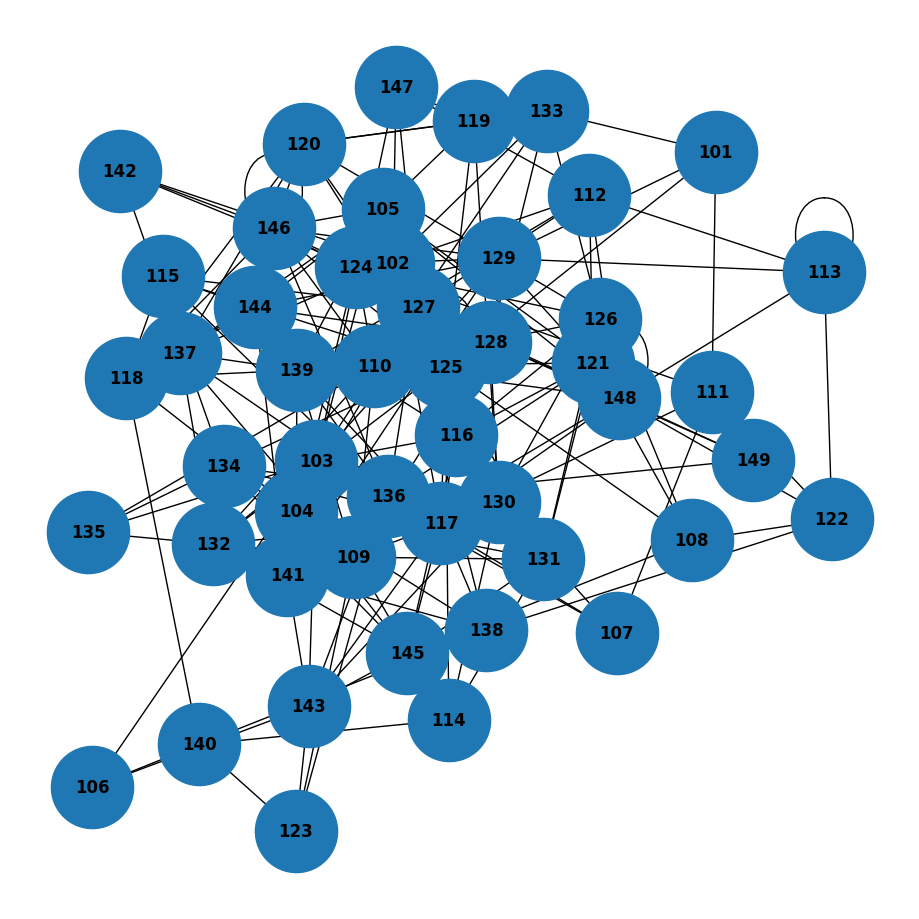

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
# the function will plot the source and destination nodes and connect them by meand of undirected line
def plot_undirected_graph(edge_list):
    plt.figure(figsize=(9,9))
    gplot=nx.Graph()
    for row in edge_list.select("src", "dst").take(1000):
        gplot.add_edge(row["src"], row["dst"])
    nx.draw(gplot, with_labels=True, font_weight="bold", node_size=3500)
plot_undirected_graph(g.edges)

Analyzing a graph of customer churn data can provide valuable insights into the patterns and trends of customer behavior. Here, Nodes represents individual customers, and the *edges* could represent some form of interaction or relationship between them. The PageRank algorithm, which you've used, assigns each customer a score. Customers with higher scores are considered more "influential" in the network. These could be customers who have a lot of connections or who are connected to other highly influential customers.

If we assume that an edge between two customers represents some form of interaction (e.g., they both bought the same product, they're in the same demographic group, etc.), customers with a higher PageRank score could potentially influence others' buying behaviors.

In the context of churn analysis, these influential customers are very important. If they churn, they might influence others in their network to do the same. Identifying these customers could allow for targeted marketing or personalized incentives to prevent them from churning.

As a final business outcome, this analysis can help the company identify key customers to focus their customer retention efforts on. By preventing these influential customers from churning, they could potentially reduce overall churn and increase customer lifetime value.

In [24]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans

# Data Preprocessing
## Indexing the 'Gender' and 'State' categorical columns
indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_index").fit(ecomm_churn_data)
    for column in ["Gender", "State"]
]

## Assembling features
assembler = VectorAssembler(inputCols=["Age", "Gender_index", "State_index", "TotalPurchase"],
                            outputCol="features")

## Feature scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# K-means clustering
kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="cluster").setK(5)  # Adjust 'setK' as needed

# Creating Pipeline
pipeline = Pipeline(stages=indexers + [assembler, scaler, kmeans])
model = pipeline.fit(ecomm_churn_data)

# Transform the dataset with the pipeline
clustered = model.transform(ecomm_churn_data)

# Results
clustered.select("CustomerId", "cluster").show()

+----------+-------+
|CustomerId|cluster|
+----------+-------+
|       101|      2|
|       102|      0|
|       103|      4|
|       104|      2|
|       105|      4|
|       106|      1|
|       107|      0|
|       108|      0|
|       109|      4|
|       110|      4|
|       111|      2|
|       112|      4|
|       113|      1|
|       114|      1|
|       115|      4|
|       116|      2|
|       117|      3|
|       118|      4|
|       119|      1|
|       120|      2|
+----------+-------+
only showing top 20 rows



In [25]:
# Indexing Gender column
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndexed")

# Assembling features to use for clustering
assembler = VectorAssembler(
    inputCols=["Age", "GenderIndexed", "TotalPurchase"],
    outputCol="features")

In [26]:
# Initializing KMeans
kmeans = KMeans(featuresCol="features", predictionCol="prediction", k=5) # Experiment with k

# Creating Pipeline
pipeline = Pipeline(stages=[gender_indexer, assembler, kmeans])

model = pipeline.fit(ecomm_churn_data)

# Transforming the dataset
clustered = model.transform(ecomm_churn_data)

# Results
clustered.select("CustomerId", "prediction").show()

+----------+----------+
|CustomerId|prediction|
+----------+----------+
|       101|         2|
|       102|         3|
|       103|         0|
|       104|         2|
|       105|         1|
|       106|         4|
|       107|         1|
|       108|         0|
|       109|         1|
|       110|         1|
|       111|         2|
|       112|         1|
|       113|         4|
|       114|         4|
|       115|         1|
|       116|         2|
|       117|         3|
|       118|         1|
|       119|         4|
|       120|         2|
+----------+----------+
only showing top 20 rows



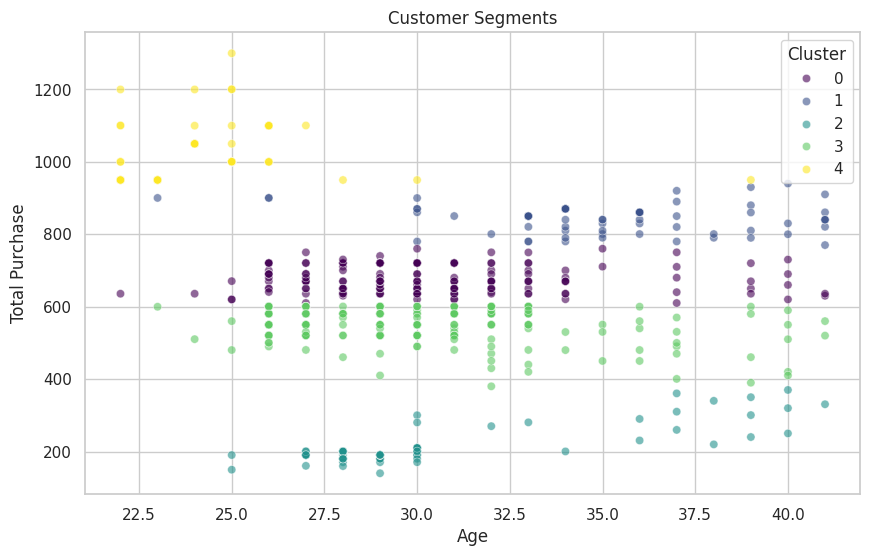

In [27]:
pandas_df = clustered.select("Age", "TotalPurchase", "prediction").toPandas()
import matplotlib.pyplot as plt
import seaborn as sns

# Setting style
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

# Plotting
sns.scatterplot(data=pandas_df, x="Age", y="TotalPurchase", hue="prediction", palette="viridis", alpha=0.6)

plt.title('Customer Segments')
plt.xlabel('Age')
plt.ylabel('Total Purchase')
plt.legend(title='Cluster')
plt.show()



This KMeans clustering analysis provides a valuable visual representation of how customers naturally form distinct groups based on age, total purchase, and gender. By discerning these segments, businesses gain insights into the diverse characteristics and preferences within their customer base.

This understanding empowers companies to tailor their marketing strategies and services to cater specifically to the unique needs of each cluster. By aligning offerings with customer preferences, businesses can enhance overall customer engagement and satisfaction. Additionally, this targeted approach enables more effective resource allocation, ensuring that marketing efforts are optimized to resonate with the distinct demographics and behaviors represented in each cluster.

Ultimately, the business gains a competitive edge by fostering a more personalized and customer-centric approach, leading to increased loyalty, higher retention rates, and improved overall performance.